In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

c:\Users\chanyoung\anaconda3\envs\coolingts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [3]:

from pts.model.time_grad import TimeGradEstimator
from pts import Trainer

c:\Users\chanyoung\anaconda3\envs\coolingts\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [4]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [5]:
dataset = get_dataset("traffic", regenerate=False)

In [6]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

print('Done grouper')
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

Done grouper


In [7]:
from diffusers import DEISMultistepScheduler
scheduler = DEISMultistepScheduler( num_train_timesteps=150, beta_end=0.1, )

In [8]:
graphestimator = TimeGradEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    # target_dim = int(dataset.metadata.feat_static_cat[0].cardinality),
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=10,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", devices="auto"),
    )

In [9]:
graphpredictor = graphestimator.train(dataset_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\chanyoung\anaconda3\envs\coolingts\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | In sizes | Out sizes        
-----------------------------------------------------------------------
0 | model | TimeGradModel | 1.1 M  | ?        | [1, 100, 24, 862]
-------------------------------------

Epoch 0: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.401]

Epoch 0, global step 50: 'train_loss' reached 0.40061 (best 0.40061), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [01:18<00:00,  0.63it/s, v_num=6, train_loss=0.260]

Epoch 1, global step 100: 'train_loss' reached 0.25950 (best 0.25950), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [01:15<00:00,  0.67it/s, v_num=6, train_loss=0.217]

Epoch 2, global step 150: 'train_loss' reached 0.21665 (best 0.21665), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.197]

Epoch 3, global step 200: 'train_loss' reached 0.19709 (best 0.19709), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [01:12<00:00,  0.69it/s, v_num=6, train_loss=0.185]

Epoch 4, global step 250: 'train_loss' reached 0.18451 (best 0.18451), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [01:13<00:00,  0.68it/s, v_num=6, train_loss=0.180]

Epoch 5, global step 300: 'train_loss' reached 0.17997 (best 0.17997), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [01:11<00:00,  0.70it/s, v_num=6, train_loss=0.174]

Epoch 6, global step 350: 'train_loss' reached 0.17361 (best 0.17361), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.171]

Epoch 7, global step 400: 'train_loss' reached 0.17117 (best 0.17117), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.167]

Epoch 8, global step 450: 'train_loss' reached 0.16672 (best 0.16672), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [01:12<00:00,  0.69it/s, v_num=6, train_loss=0.165]

Epoch 9, global step 500: 'train_loss' reached 0.16505 (best 0.16505), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.162]

Epoch 10, global step 550: 'train_loss' reached 0.16210 (best 0.16210), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [01:17<00:00,  0.64it/s, v_num=6, train_loss=0.158]

Epoch 11, global step 600: 'train_loss' reached 0.15836 (best 0.15836), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.161]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.161]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [01:13<00:00,  0.68it/s, v_num=6, train_loss=0.156]

Epoch 14, global step 750: 'train_loss' reached 0.15592 (best 0.15592), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.157]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.154]

Epoch 16, global step 850: 'train_loss' reached 0.15398 (best 0.15398), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [01:20<00:00,  0.62it/s, v_num=6, train_loss=0.155]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.151]

Epoch 18, global step 950: 'train_loss' reached 0.15143 (best 0.15143), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.152]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [01:16<00:00,  0.66it/s, v_num=6, train_loss=0.153]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.150]

Epoch 21, global step 1100: 'train_loss' reached 0.14975 (best 0.14975), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.150]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.150]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.149]

Epoch 24, global step 1250: 'train_loss' reached 0.14882 (best 0.14882), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [01:12<00:00,  0.69it/s, v_num=6, train_loss=0.150]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.147]

Epoch 26, global step 1350: 'train_loss' reached 0.14733 (best 0.14733), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.146]

Epoch 27, global step 1400: 'train_loss' reached 0.14562 (best 0.14562), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.145]

Epoch 28, global step 1450: 'train_loss' reached 0.14455 (best 0.14455), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.148]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.145]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [01:13<00:00,  0.68it/s, v_num=6, train_loss=0.144]

Epoch 31, global step 1600: 'train_loss' reached 0.14380 (best 0.14380), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.146]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.146]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.146]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.145]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [01:19<00:00,  0.63it/s, v_num=6, train_loss=0.144]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [01:17<00:00,  0.64it/s, v_num=6, train_loss=0.143]

Epoch 37, global step 1900: 'train_loss' reached 0.14308 (best 0.14308), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [01:12<00:00,  0.69it/s, v_num=6, train_loss=0.143]

Epoch 38, global step 1950: 'train_loss' reached 0.14290 (best 0.14290), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.143]

Epoch 39, global step 2000: 'train_loss' reached 0.14288 (best 0.14288), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.143]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [01:16<00:00,  0.66it/s, v_num=6, train_loss=0.142]

Epoch 41, global step 2100: 'train_loss' reached 0.14228 (best 0.14228), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.141]

Epoch 42, global step 2150: 'train_loss' reached 0.14120 (best 0.14120), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.139]

Epoch 43, global step 2200: 'train_loss' reached 0.13889 (best 0.13889), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.140]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [01:13<00:00,  0.68it/s, v_num=6, train_loss=0.140]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.140]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.140]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.140]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [01:16<00:00,  0.66it/s, v_num=6, train_loss=0.140]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.137]

Epoch 50, global step 2550: 'train_loss' reached 0.13707 (best 0.13707), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=50-step=2550.ckpt' as top 1


Epoch 51: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.140]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [01:13<00:00,  0.68it/s, v_num=6, train_loss=0.141]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.139]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [01:16<00:00,  0.66it/s, v_num=6, train_loss=0.140]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: |          | 50/? [01:16<00:00,  0.66it/s, v_num=6, train_loss=0.139]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: |          | 50/? [01:18<00:00,  0.63it/s, v_num=6, train_loss=0.138]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [01:18<00:00,  0.63it/s, v_num=6, train_loss=0.140]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.138]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.137]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.140]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.139]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.134]

Epoch 62, global step 3150: 'train_loss' reached 0.13448 (best 0.13448), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=62-step=3150.ckpt' as top 1


Epoch 63: |          | 50/? [01:17<00:00,  0.64it/s, v_num=6, train_loss=0.136]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: |          | 50/? [01:17<00:00,  0.64it/s, v_num=6, train_loss=0.136]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.137]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |          | 50/? [01:17<00:00,  0.64it/s, v_num=6, train_loss=0.135]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.136]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |          | 50/? [01:13<00:00,  0.68it/s, v_num=6, train_loss=0.136]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.135]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: |          | 50/? [01:18<00:00,  0.63it/s, v_num=6, train_loss=0.135]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.134]

Epoch 71, global step 3600: 'train_loss' reached 0.13367 (best 0.13367), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=71-step=3600.ckpt' as top 1


Epoch 72: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.136]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |          | 50/? [01:19<00:00,  0.63it/s, v_num=6, train_loss=0.133]

Epoch 73, global step 3700: 'train_loss' reached 0.13320 (best 0.13320), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=73-step=3700.ckpt' as top 1


Epoch 74: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.134]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |          | 50/? [01:19<00:00,  0.63it/s, v_num=6, train_loss=0.135]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.135]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.134]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [01:15<00:00,  0.67it/s, v_num=6, train_loss=0.134]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.136]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.135]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.135]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.134]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: |          | 50/? [01:15<00:00,  0.67it/s, v_num=6, train_loss=0.134]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: |          | 50/? [01:19<00:00,  0.63it/s, v_num=6, train_loss=0.135]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.132]

Epoch 85, global step 4300: 'train_loss' reached 0.13202 (best 0.13202), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=85-step=4300.ckpt' as top 1


Epoch 86: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.133]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.134]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.133]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: |          | 50/? [01:15<00:00,  0.66it/s, v_num=6, train_loss=0.134]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: |          | 50/? [01:20<00:00,  0.62it/s, v_num=6, train_loss=0.132]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.134]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |          | 50/? [01:19<00:00,  0.63it/s, v_num=6, train_loss=0.133]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: |          | 50/? [01:17<00:00,  0.65it/s, v_num=6, train_loss=0.134]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.134]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.132]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |          | 50/? [01:14<00:00,  0.67it/s, v_num=6, train_loss=0.133]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.131]

Epoch 97, global step 4900: 'train_loss' reached 0.13093 (best 0.13093), saving model to 'c:\\Users\\chanyoung\\Desktop\\test_pytorchts\\test_pytorchts\\lightning_logs\\version_6\\checkpoints\\epoch=97-step=4900.ckpt' as top 1


Epoch 98: |          | 50/? [01:16<00:00,  0.65it/s, v_num=6, train_loss=0.133]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.131]

Epoch 99, global step 5000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [01:18<00:00,  0.64it/s, v_num=6, train_loss=0.131]


In [10]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=graphpredictor,
                                                 num_samples=100)

In [11]:
forecasts = list(forecast_it)
targets = list(ts_it)

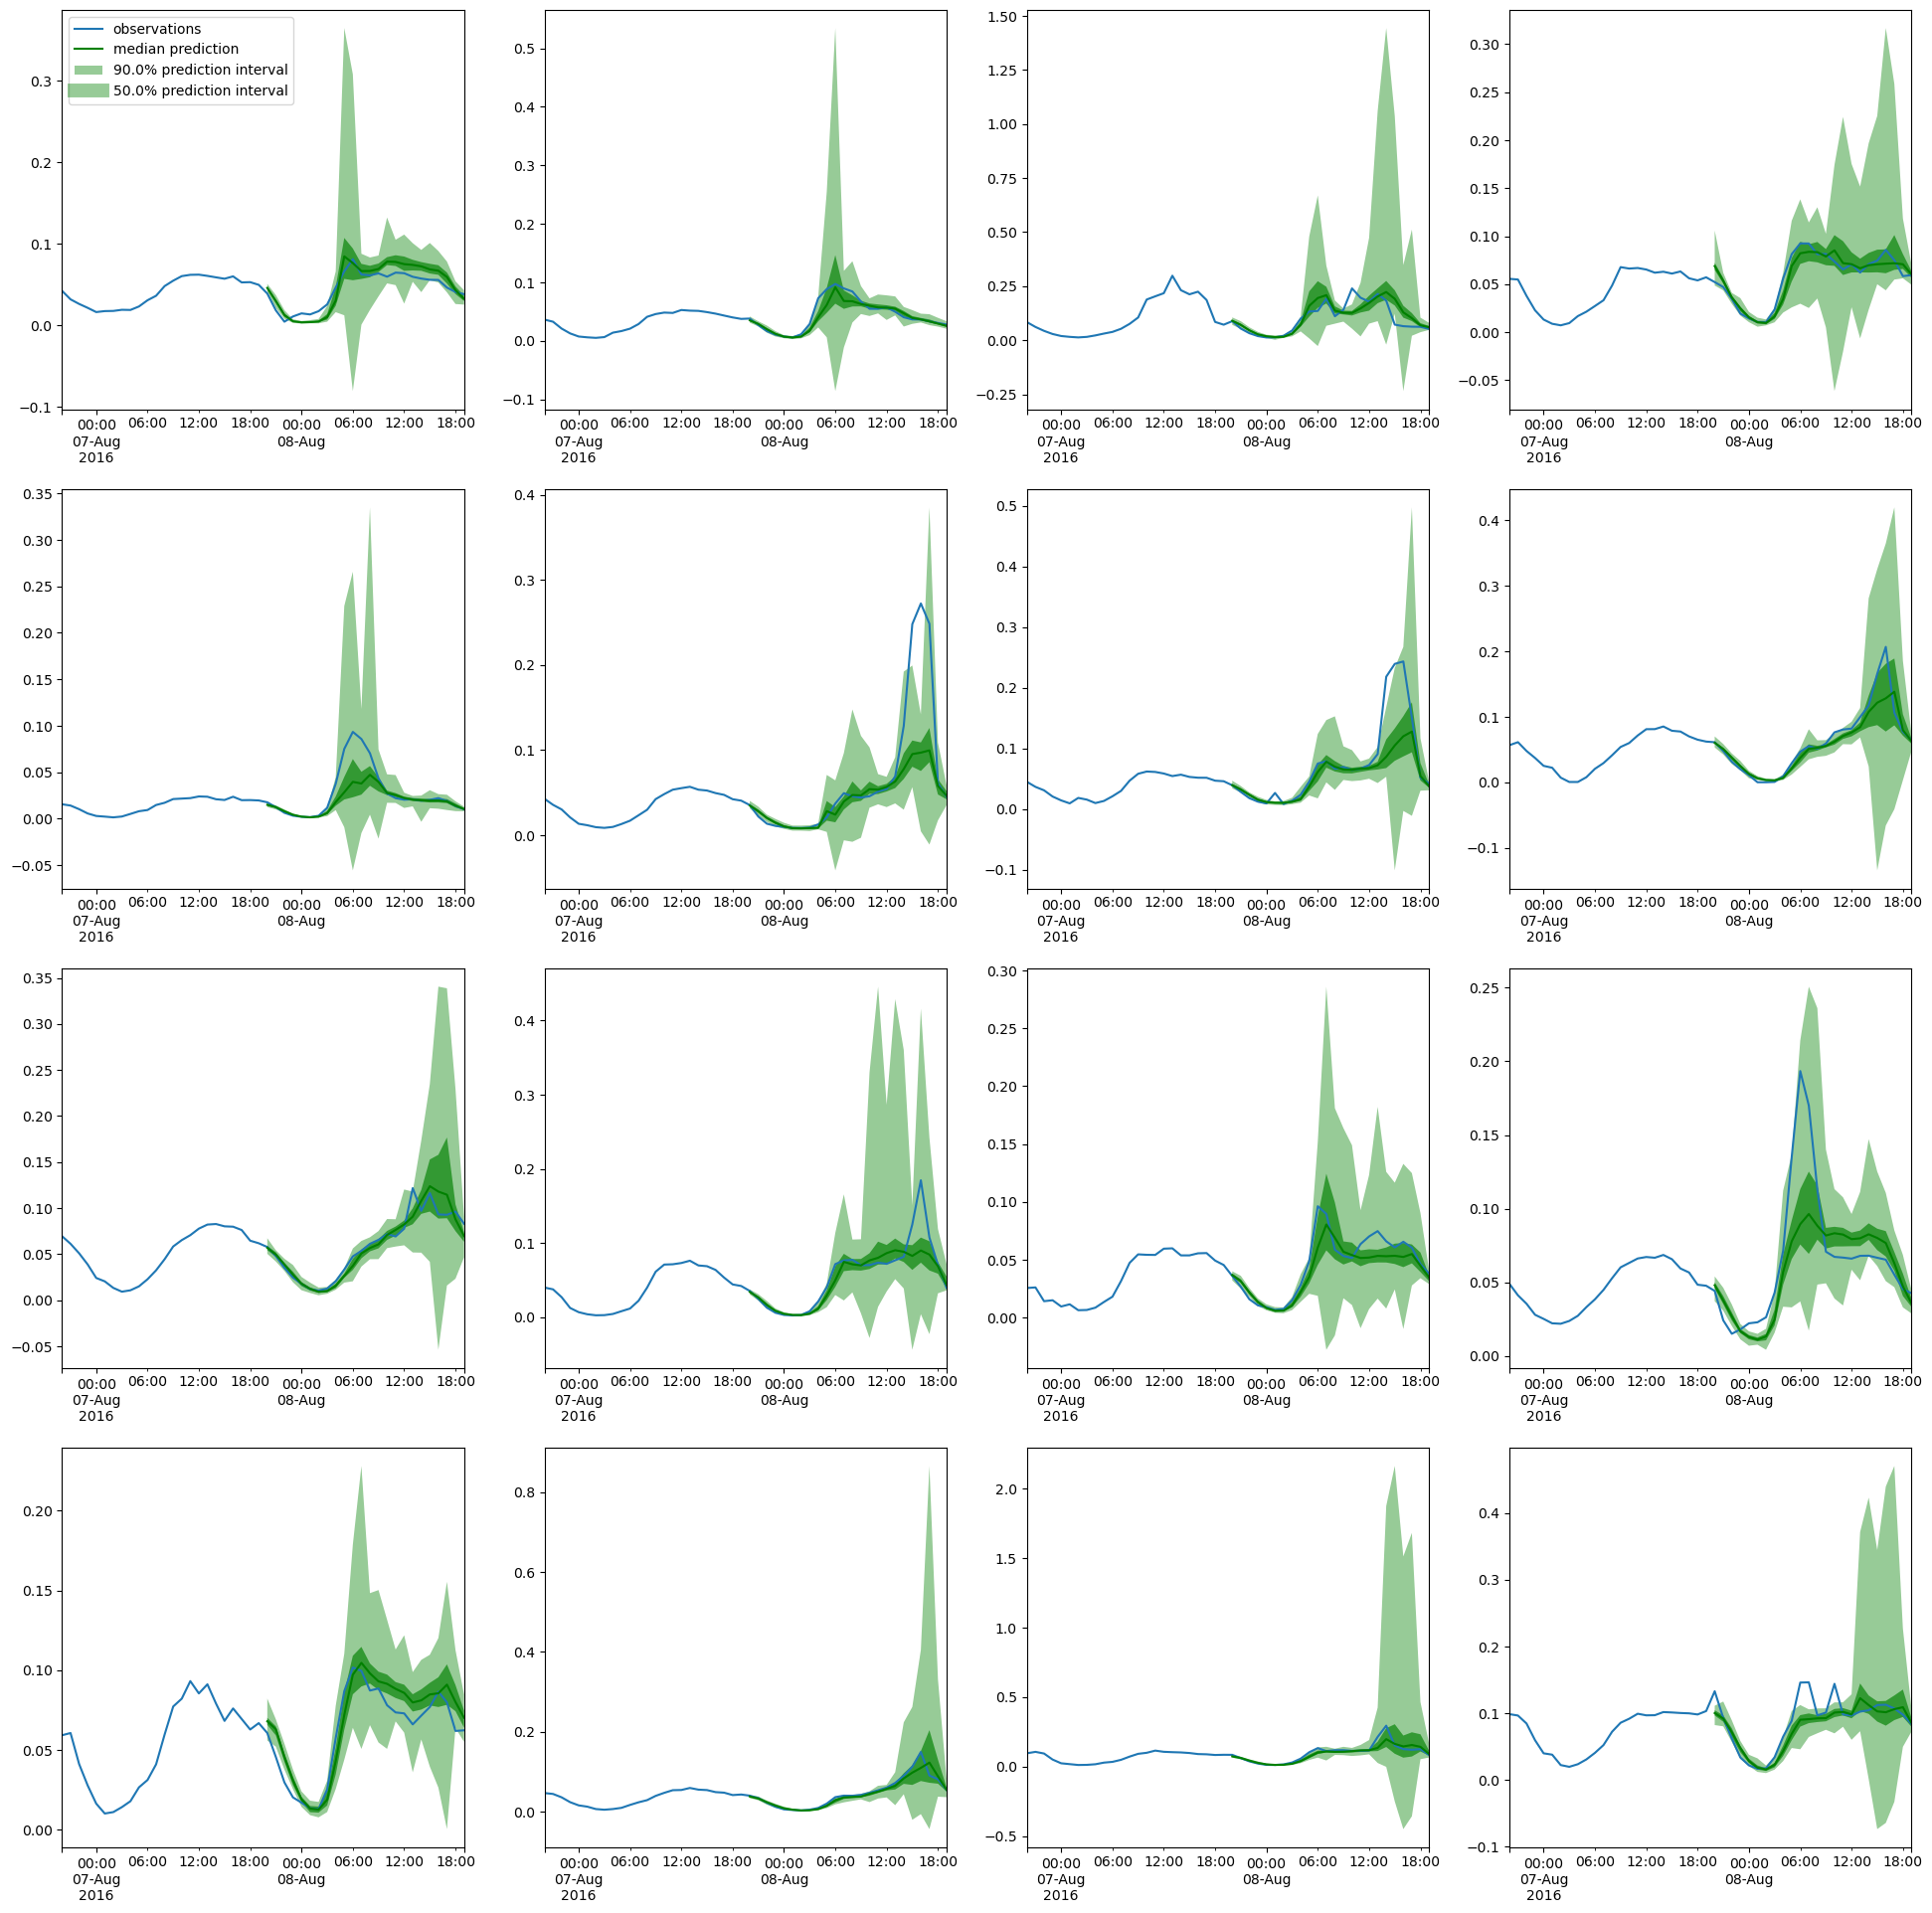

In [12]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [13]:
graphevaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [14]:
agg_metric, item_metrics = graphevaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 72.94it/s]
Running evaluation: 7it [00:00, 72.94it/s]
Running evaluation: 7it [00:00, 72.19it/s]
Running evaluation: 7it [00:00, 79.56it/s]
Running evaluation: 7it [00:00, 82.38it/s]
Running evaluation: 7it [00:00, 76.93it/s]
Running evaluation: 7it [00:00, 94.63it/s]
Running evaluation: 7it [00:00, 58.36it/s]
Running evaluation: 7it [00:00, 90.94it/s]
Running evaluation: 7it [00:00, 85.39it/s]
Running evaluation: 7it [00:00, 93.36it/s]
Running evaluation: 7it [00:00, 55.57it/s]
Running evaluation: 7it [00:00, 79.57it/s]
Running evaluation: 7it [00:00, 76.93it/s]
Running evaluation: 7it [00:00, 85.39it/s]
Running evaluation: 7it [00:00, 84.36it/s]
Running evaluation: 7it [00:00, 72.18it/s]
Running evaluation: 7it [00:00, 59.85it/s]
Running evaluation: 7it [00:00, 68.63it/s]
Running evaluation: 7it [00:00, 86.43it/s]
Running evaluation: 7it [00:00, 73.71it/s]
Running evaluation: 7it [00:00, 80.47it/s]
Running evaluation: 7it [00:00, 83.34it/s]
Running eva

In [15]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.17969827262127486
ND: 0.2032621031099128
NRMSE: 0.6438768380174175

CRPS-Sum: 0.062250210369075645
ND-Sum: 0.08259870294198225
NRMSE-Sum: 0.12697069052036547
